In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
use_tpu = True #@param {type:"boolean"}

if use_tpu:
    assert 'COLAB_TPU_ADDR' in os.environ, 'Missing TPU; did you request a TPU in Notebook Settings?'

if 'COLAB_TPU_ADDR' in os.environ:
  TF_MASTER = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
else:
  TF_MASTER=''

In [4]:
!ls /content/drive/MyDrive/ASEML_dataset/
!cp drive/MyDrive/ASEML_dataset/tokenization.py .

tokenization.py  tokenize_dataset.py  train.csv  valid.csv


In [5]:
import pandas as pd
import numpy as np 
import ast 
import tokenization
from vocabulary import Vocabulary

In [108]:
train = pd.read_csv('/content/drive/MyDrive/ASEML_dataset/train.csv')
test  = pd.read_csv('/content/drive/MyDrive/ASEML_dataset/valid.csv')




In [99]:
#parameters
sen_len  = 22
vocab_size = 250 
# TPU address
tpu_address = TF_MASTER


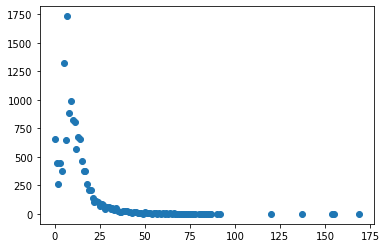

In [8]:
import matplotlib.pyplot as plt
dist={}

train_orig = pd.read_csv('/content/drive/MyDrive/ASEML_dataset/train.csv')
tokenizer = tokenization.C_Tokenizer()
for index in train_orig.index:
  tar_line = ast.literal_eval(train_orig['targetLineTokens'][index])
  line = ' '.join(tar_line)
  toks,types = tokenizer.tokenize(line)
  if len(toks) in dist :
    dist[len(toks)] +=1
  else:
    dist[len(toks)] = 1
plt.scatter(dist.keys(),dist.values())
plt.show()

In [109]:
def pre_process(data):
  tokenizer = tokenization.C_Tokenizer()
  data['src_id_var'] = ""
  data['src_var_id'] = ""
  data['src_lc_s'] = ""
  data['src_lc_c']= ""
  data['src_lc_n']= ""
  data['src_lc_comm']= ""
  if 'targetLineTokens' in data.columns:
    data['tar_id_var'] = ""
    data['tar_var_id'] = ""
    data['tar_lc_s'] = ""
    data['tar_lc_c']= ""
    data['tar_lc_n']= ""
    data['tar_lc_comm']= ""


  for index in data.index:
    src_line = ast.literal_eval(data['sourceLineTokens'][index])
    line = ' '.join(src_line)
    toks,types = tokenizer.tokenize(line)
    num_var = list(set([toks[i] for i in range(len(toks)) if types[i]=='name']))
    var_num = {num_var[i]:i for i in range(len(num_var))}
    data['src_id_var'][index] = num_var
    data['src_var_id'][index] = var_num
    s_list=[]
    c_list=[]
    n_list=[]
    com_list=[]
    chk = var_num.keys();

    for i,s in enumerate(toks):
      if s in chk:
        toks[i]='v'+str(var_num[s])
      if types[i] == 'string':
        s_list.append(toks[i])
        toks[i]='lc_s'
      if types[i] == 'char':
        c_list.append(toks[i])
        toks[i]='lc_c'
      if types[i] == 'number':
        n_list.append(toks[i])
        toks[i]='lc_n'
      if types[i] == 'comment':
        com_list.append(toks[i])
        toks[i] = 'lc_comm'
    
    normalised= ['SOS']
    normalised.extend([toks[x] for x in range(min(sen_len-2,len(toks)))])
    normalised.extend(['PAD' for x in range(sen_len -1 - len(normalised))])
    normalised.append('EOS')
     
    data['sourceLineTokens'][index] = normalised
    data['src_lc_s'][index] = s_list
    data['src_lc_c'][index]= c_list
    data['src_lc_n'][index]= n_list
    data['src_lc_comm'][index]= com_list
      
    
    if 'targetLineTokens' in data.columns:
      tar_line = ast.literal_eval(data['targetLineTokens'][index])
      line = ' '.join(tar_line)
      toks,types = tokenizer.tokenize(line)
      
      num_var = list(set([toks[i] for i in range(len(toks)) if types[i]=='name']))
      var_num = {num_var[i]:i for i in range(len(num_var))}
      data['tar_id_var'][index] = num_var
      data['tar_var_id'][index] = var_num
      s_list=[]
      c_list=[]
      n_list=[]
      com_list=[]
      chk = var_num.keys();
      for i,s in enumerate(toks):
        if s in chk:
          toks[i]='v'+str(var_num[s])
        if types[i] == 'string':
          s_list.append(toks[i])
          toks[i]='lc_s'
        if types[i] == 'char':
          c_list.append(toks[i])
          toks[i]='lc_c'
        if types[i] == 'number':
          n_list.append(toks[i])
          toks[i]='lc_n'
        if types[i] == 'comment':
          com_list.append(toks[i])
          toks[i] = 'lc_comm'
      
      
      
      normalised= ['SOS']
      normalised.extend([toks[x] for x in range(min(sen_len-2,len(toks)))])
      normalised.extend(['PAD' for x in range(sen_len -1 - len(normalised))])
      normalised.append('EOS')
     
      data['targetLineTokens'][index] = normalised
      data['tar_lc_s'][index] = s_list
      data['tar_lc_c'][index]= c_list
      data['tar_lc_n'][index]= n_list
      data['tar_lc_comm'][index]= com_list
    
     
      


In [110]:
pre_process(train)
pre_process(test)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to b

In [111]:
encoder_vocab = Vocabulary('encoder_vocab')
decoder_vocab = Vocabulary('decoder_vocab')
for line in train['sourceLineTokens']:
  encoder_vocab.add_sentence(line)

for line in train['targetLineTokens']:
  decoder_vocab.add_sentence(line)

print('Encoder vocab word count : ',encoder_vocab.num_words)
print('Encoder vocab longest sentence ',encoder_vocab.longest_sentence)

encoder_input_data = np.zeros(
    (len(train),encoder_vocab.longest_sentence, encoder_vocab.num_words), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(train), encoder_vocab.longest_sentence, encoder_vocab.num_words), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(train), encoder_vocab.longest_sentence, encoder_vocab.num_words), dtype="float32"
)
for i, (input_text, target_text) in enumerate(zip(train['sourceLineTokens'],train['targetLineTokens'])):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, encoder_vocab.word2index[char]] = 1.0
    
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        if char in encoder_vocab.word2index:
          decoder_input_data[i, t, encoder_vocab.word2index[char]] = 1.0
        else:
          decoder_input_data[i, t, encoder_vocab.word2index['OOV_Token']] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            if char in encoder_vocab.word2index:
              decoder_target_data[i, t-1, encoder_vocab.word2index[char]] = 1.0
            else:
              decoder_target_data[i, t-1, encoder_vocab.word2index['OOV_Token']] = 1.0
            

Encoder vocab word count :  422
Encoder vocab longest sentence  22


In [94]:
import tensorflow as tf 
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(TF_MASTER)
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.experimental.TPUStrategy(resolver)

INFO:tensorflow:Initializing the TPU system: grpc://10.100.214.18:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.100.214.18:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [115]:
import tensorflow as tf
from tensorflow import keras
batch_size = 32  # Batch size for training.
epochs = 22  # Number of epochs to train for.
latent_dim_encoder = 160
latent_dim_decoder = 160

In [116]:
num_encoder_tokens = encoder_vocab.num_words
num_decoder_tokens = encoder_vocab.num_words

# Define an input sequence and process it.
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.LSTM(latent_dim_encoder, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = keras.layers.LSTM(latent_dim_decoder, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [119]:
#Train model 

model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)

model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
)
# Save model
model.save("third.h5")

Epoch 1/22
367/367 [==============================] - 32s 78ms/step - loss: 2.0591 - accuracy: 0.5332 - val_loss: 1.2655 - val_accuracy: 0.6272
Epoch 2/22
367/367 [==============================] - 24s 64ms/step - loss: 1.0847 - accuracy: 0.6632 - val_loss: 0.8915 - val_accuracy: 0.6895
Epoch 3/22
367/367 [==============================] - 23s 63ms/step - loss: 0.7612 - accuracy: 0.7344 - val_loss: 0.6579 - val_accuracy: 0.7709
Epoch 4/22
367/367 [==============================] - 23s 62ms/step - loss: 0.6312 - accuracy: 0.7704 - val_loss: 0.6193 - val_accuracy: 0.7801
Epoch 5/22
367/367 [==============================] - 23s 62ms/step - loss: 0.5580 - accuracy: 0.7904 - val_loss: 0.5563 - val_accuracy: 0.7926
Epoch 6/22
367/367 [==============================] - 23s 62ms/step - loss: 0.5202 - accuracy: 0.8042 - val_loss: 0.4854 - val_accuracy: 0.8152
Epoch 7/22
367/367 [==============================] - 23s 62ms/step - loss: 0.4710 - accuracy: 0.8230 - val_loss: 0.4826 - val_accuracy:

In [147]:
# Restore the model and construct the encoder and decoder.
model_temp = model 
model = keras.models.load_model("third.h5")

encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim_encoder,)) #input 3
decoder_state_input_c = keras.Input(shape=(latent_dim_encoder,)) # input 4
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

# Reverse-lookup token index to decode sequences back to
# something readable.
# reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
# reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, encoder_vocab.num_words))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, encoder_vocab.word2index['SOS']] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ["SOS"]
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = encoder_vocab.index2word[sampled_token_index]
        decoded_sentence.append(sampled_char)

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "EOS" or len(decoded_sentence) > decoder_vocab.longest_sentence:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1,  encoder_vocab.num_words))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence


In [141]:
def de_normalise(toks,index,data):
  #Removing SOS ,EOS , OOV 
  c=s=com=n=0
  toks = [i for i in toks if i not in ('SOS','EOS','PAD')]
  
  for i,x in enumerate(toks):
    if (x[0]=='v' and x[1:].isdigit()):
        id= int(x[1:])
        if len(data['src_id_var'][index]) > 0:
          toks[i] = data['src_id_var'][index][id%(len(data['src_id_var'][index]))]
        continue
    if x == 'lc_s' and s < len(data['src_lc_s'][index]) :
      toks[i]=data['src_lc_s'][index][s]
      s+=1
      continue
    if x == 'lc_c' and c < len(data['src_lc_c'][index]):
      toks[i]=data['src_lc_c'][index][c]
      c+=1
      continue
    if x == 'lc_n' and n < len(data['src_lc_n'][index]):
      toks[i]=data['src_lc_n'][index][n]
      n+=1
      continue
    if x == 'lc_com' and com < len(data['src_lc_com'][index]):
      toks[i]=data['src_lc_com'][index][com]
      com+=1
      continue
    
  return toks
      




In [136]:
import matplotlib.pyplot as plt
dist={}

train_orig = pd.read_csv('/content/drive/MyDrive/ASEML_dataset/train.csv')
test_orig = pd.read_csv('/content/drive/MyDrive/ASEML_dataset/valid.csv')
tokenizer = tokenization.C_Tokenizer()
for index in train_orig.index:
  tar_line = ast.literal_eval(train_orig['targetLineTokens'][index])
  line = ' '.join(tar_line)
  toks,types = tokenizer.tokenize(line)
  train_orig['targetLineTokens'][index] = toks
for index in test_orig.index: 
  tar_line = ast.literal_eval(test_orig['targetLineTokens'][index])
  line = ' '.join(tar_line)
  toks,types = tokenizer.tokenize(line)
  test_orig['targetLineTokens'][index] = toks
  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [148]:
model.summary()

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           [(None, None, 422)]  0                                            
__________________________________________________________________________________________________
input_28 (InputLayer)           [(None, None, 422)]  0                                            
__________________________________________________________________________________________________
lstm_20 (LSTM)                  [(None, 160), (None, 373120      input_27[0][0]                   
__________________________________________________________________________________________________
lstm_21 (LSTM)                  [(None, None, 160),  373120      input_28[0][0]                   
                                                                 lstm_20[0][1]             

In [137]:
# Encoder input for test data
encoder_input_data = np.zeros(
    (len(test),encoder_vocab.longest_sentence, encoder_vocab.num_words), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(test), encoder_vocab.longest_sentence, encoder_vocab.num_words), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(test), encoder_vocab.longest_sentence, encoder_vocab.num_words), dtype="float32"
)
for i, (input_text, target_text) in enumerate(zip(test['sourceLineTokens'],test['targetLineTokens'])):
    for t, char in enumerate(input_text):
      if char in encoder_vocab.word2index:
        encoder_input_data[i, t, encoder_vocab.word2index[char]] = 1.0
      else:
        encoder_input_data[i, t, encoder_vocab.word2index['OOV_Token']] = 1.0
    
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        if char in encoder_vocab.word2index:
          decoder_input_data[i, t, encoder_vocab.word2index[char]] = 1.0
        else:
          decoder_input_data[i, t, encoder_vocab.word2index['OOV_Token']] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            if char in encoder_vocab.word2index:
              decoder_target_data[i, t-1, encoder_vocab.word2index[char]] = 1.0
            else:
              decoder_target_data[i, t-1, encoder_vocab.word2index['OOV_Token']] = 1.0

In [149]:
# Predicting sequeneces 
correct = 0
samples = 10
test_orig['fixedTokens'] = ""
for index in range(samples):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[index : index + 1]
    decoded_sentence = decode_sequence(input_seq)
    decoded_sentence = de_normalise(decoded_sentence,index,test)
    test_orig['fixedTokens'][index]=decoded_sentence
    if decoded_sentence == test_orig['targetLineTokens'][index]:
      correct+=1
    if index % 100 == 0 and index != 0: 
      print('accuracy: after',index,': ',correct/index)

print('Accuracy : ',correct/samples)
    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


Accuracy :  0.2


In [156]:
# load and store dictionaires 
import pickle
file_to_store = open("en_vocab.pickle", "wb")
pickle.dump(encoder_vocab, file_to_store)
file_to_store.close()

file_to_store = open("dec_vocab.pickle", "wb")
pickle.dump(decoder_vocab, file_to_store)
file_to_store.close()

In [155]:
file_to_read = open("vocab.pickle", "rb")


422


In [167]:
a=pd.read_csv('valid_output.csv')
print(ast.literal_eval(a['fixedTokens'][0]))
print(a['targetLineTokens'][0])

['if', '(', '(', 'x', '(', 'facdtorial', ')', '&&', '(', 'x', '>=', 'n2', ')', ')', '&&', '(', 'facdtorial', '<', 'x']
['if', '(', '(', 'factorial', '(', 'x', ')', '>=', 'n1', ')', '&&', '(', 'factorial', '(', 'x', ')', '<=', 'n2', ')', ')', '{']
